# Molecular optimization with hierarchical coarse-grained models

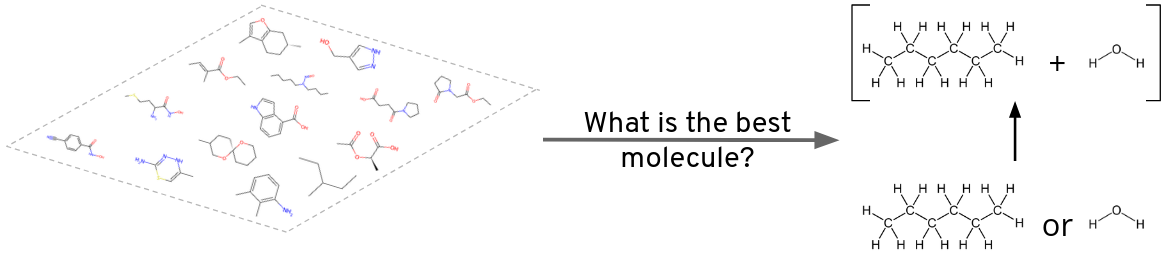

In this tutorial, we will perform a simple molecular optimization using hierarchical coarse-graining and Bayesian optimization. The goal is to efficiently identify a [**small molecule**](https://en.wikipedia.org/wiki/Small_molecule) that shows a strong preference for residing in a hexane-water mixture rather than in pure water or pure hexane. This preference can be quantified using a free energy difference, known as the **transfer free energy**. Thus, our optimization target is to maximize this transfer free energy.

While this oil-water target system is relatively simple and basic chemical intuition might suggest what kind of molecules we expect from the optimization, the same methodology can be extended to more complex systems where no prior knowledge of relevant molecules exists. To keep the tutorial accessible, we introduce additional simplifications, such as restricting small molecules to a maximum of 10 heavy atoms. Despite these constraints, the approach outlined here captures the fundamental principles of the optimization strategy.

The tutorial is based on the arXiv paper [Navigating Chemical Space: Multi-Level Bayesian Optimization with Hierarchical Coarse-Graining](https://doi.org/10.48550/arXiv.2505.04169).

### **Overview**
The following list outlines the structure of the tutorial. Parts 4 and 5 contain a machine learning component, while Parts 1 through 3 introduce preliminaries related to coarse-graining and molecular dynamics (MD) simulations.
1. Coarse-graining approach *(2 min)*
2. Simulations of the target system *(5 min)*
3. Molecule enumeration *(5 min)*
4. Latent-space encoding *(10 min)*
5. Molecular optimization *(13 min)*
6. Analysis and derivation of design rules *(remaining time)*

The following code imports all required libraries, sets the working directory to the `simulation-files` folder, and checks the version of the molecular dynamics simulation program [GROMACS](https://www.gromacs.org/):

In [ ]:
# Imports python packages and checks GROMACS version
import os
import time
import warnings
from itertools import combinations_with_replacement
import numpy as np
import pandas as pd

""" Load libraries for visualizations """
from IPython.display import clear_output
import matplotlib.pyplot as plt
import MDAnalysis as mda
import nglview as nv

""" Load machine learning libraries """
import torch
import torch.nn as nn
from torch.nn.functional import one_hot, cross_entropy, softmax

""" Import rdkit """
from rdkit import Chem
from rdkit.Chem.BRICS import BRICSBuild

""" Import helper functions from custom helper script """
from helper import (
    run_molecule_simulations,
    calculate_free_energy,
    visualize_latent_space,
    SurrogateModel,
    acquisition_function,
    argmax_width_excluded_indices
)

""" Go the the simulation-files directory """
if os.path.basename(os.getcwd()) != 'simulation-files':
    os.chdir('simulation-files')

""" Check GROMACS version and GPU support """
!gmx -version | grep -Ei '(gpu support|gromacs version)'

## <ins>Coarse-graining approach</ins>

Although typically used to speed up simulations, we want to use coarse-graining to reduce the complexity of **chemical space**. There are various methods for obtaining coarse-grained (CG) representations of molecules. We will work with a coarse-graining model that maps 2 to 5 atoms to a single **coarse-grained bead/pseudo-atom** (based on the so-called [Martini3](https://doi.org/10.1038/s41592-021-01098-3) model). The following image illustrates the coarse-graining for the molecule [Lutein](https://en.wikipedia.org/wiki/Lutein) ([source](https://doi.org/10.3390/ijms25147947)):

<div style="text-align: center;">
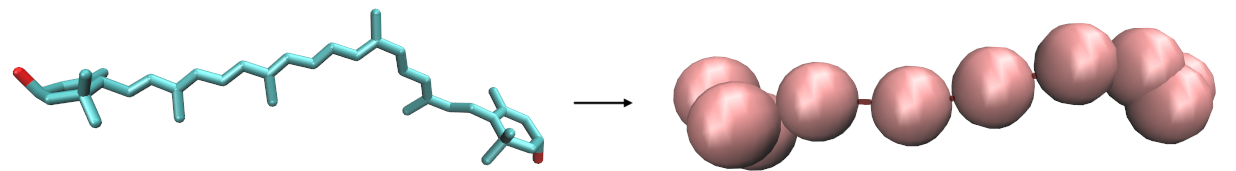
</div>

The **interactions** between the CG beads are determined by their **bead types**, which are assigned based on the underlying chemical fragments. We use a **fixed set** of bead types that can be reused across a wide range of molecules, making it a **transferable CG force field**.

Coarse-graining reduces chemical detail, allowing multiple atomistic structures to be mapped to the same CG representation. We exploit this **many-to-one relationship** to reduce the complexity of chemical space.

To keep this tutorial simple, we restrict CG molecules to a size of just **two CG beads** corresponding to molecules with up to ten atoms.

## <ins>Simulations of the target system</ins>

We begin by examining our target system: a mixture of hexane and water, two solvents that differ significantly in polarity. In our coarse-grained (CG) model, water is represented by a single bead, while hexane is modeled using two beads. As an initial step, we run a short simulation using the molecular dynamics (MD) software [GROMACS](https://www.gromacs.org):

<div style="background-color:powderblue;">
<details>

<summary>Toggle to see an explanation of the following simulation commands</summary>

* `gmx grompp` is the command to prepare a GROMACS simulation (see [here](https://manual.gromacs.org/current/onlinehelp/gmx-grompp.html) for further details)
* `-f mixture.mdp` provides a file with all the simulation parameters, e.g., temperature, number of integration steps, ... (see [here](https://manual.gromacs.org/current/user-guide/mdp-options.html) for further details)
* `-c mixture.gro` provides a file with the initial structure
* `-p mixture.top` provides a topology file that describes bonded and non-bonded interactions between atoms or CG beads
* `-o mixture/simulation.tpr` path for the output of the simulation run file
* `gmx mdrun -deffnm mixture/simulation` runs the simulation for the provided simulation run file without extension (see [here](https://manual.gromacs.org/current/onlinehelp/gmx-mdrun.html) for further information)
* `> mixture/simulation.run.log 2>&1` saves the log and error output to the specified file

Check out the contents of the individual files if you are interested!
</details>
</div>

In [ ]:
!mkdir -p mixture
!gmx grompp -f mixture.mdp -c mixture.gro -p mixture.top -o mixture/simulation.tpr > mixture/simulation.run.log 2>&1
!gmx mdrun -deffnm mixture/simulation >> mixture/simulation.run.log 2>&1

We redirect the simulation output to the file `mixture/simulation.run.log`. If the simulation was successfull, it should contain a little table with information about the simulation performance:

In [ ]:
!tail -n 7 mixture/simulation.run.log

<div style="background-color:powderblue;">
<details>

<summary>Toggle to read more about periodic boundaries</summary>
<br>
In molecular dynamics simulations, periodic boundary conditions (PBCs) are applied to eliminate boundary artifacts. Such artifacts would be especially pronounced in small simulation boxes. PBCs ensure that when a molecule exits one side of the box, it re-enters from the opposite side. While this reduces boundary-related artifacts, it can introduce others—for example, artificial self-interactions between a molecule and its periodic images. To minimize such effects, the simulation box must be appropriately sized.  

During simulations, molecules may appear split across the box boundaries—one part on one side, the rest on the opposite. This must be addressed during trajectory analysis. The first command in the cell below ensures that molecules are kept whole within the box, preventing misleading visualizations such as bonds stretching across the entire simulation box.
</details>
</div>

Let's now visualize the simulation:

In [ ]:
# Fix periodic boundaries in the trajectory file
!echo -e "0\n" | gmx trjconv -f mixture/simulation.xtc -s mixture/simulation.tpr -o mixture/simulation-no-pbc.xtc -pbc mol >> mixture/simulation.run.log 2>&1
# Load simulation trajectory with fixed periodic boundaries
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    u = mda.Universe("mixture/simulation.tpr", "mixture/simulation-no-pbc.xtc")
# Visualize trajectory
view = nv.show_mdanalysis(u)
view.add_representation('spacefill', selection=':HEX', color='gray', radius=0.5) # hexane
view.add_representation('spacefill', selection=':W', color='lightblue', radius=0.5) # water
view

<span style="color:blue">**TODO:**</span> Play the simulation and observe how the two solvents behave. What behavior do you notice over the course of the simulation?

#### Free energy calculations

In the following optimization, we want to discover a molecule with a strong **preference for the hexane-water mixture** in comparison to pure hexane or pure water. As mentioned above, we use the transfer free energies to quantify this preference. They can be calculated from molecular dynamics (MD) simulations.

To calculate the transfer free energies between the pure solvents and the mixture, we first calculate **solvation free energies** for the three individual systems: $\Delta G_{\text{Hexane}}$, $\Delta G_{\text{Water}}$, $\Delta G_{\text{Mixture}}$. Since the free energy is a state variable, we can use a thermodynamic cycle and the solvation free energies to obtain the two transfer free energies:
$$
\Delta\Delta G_{\text{Hexane}\rightarrow\text{Mixture}} = \Delta G_{\text{Mixture}} - \Delta G_{\text{Hexane}}
$$
$$
\Delta\Delta G_{\text{Water}\rightarrow\text{Mixture}} = \Delta G_{\text{Mixture}} - \Delta G_{\text{Water}}
$$
The sign of such free energy differences is arbitrary. Here, we define the difference such that a positive sign indicates a preference for the mixture. Since we want to maximize the preference for the mixture in comparison to both pure solvents we combine both transfer free energies using a minimum-function. The final optimization objective becomes:
$$
\Delta\Delta G = \min(\Delta\Delta G_{\text{Hexane}\rightarrow\text{Mixture}}, \Delta\Delta G_{\text{Water}\rightarrow\text{Mixture}})
$$

To actually calculate the free-energy values, we use a method called thermodynamic integration (TI). The details are beyond the scope of this tutorial (see [Wikipedia](https://en.wikipedia.org/wiki/Thermodynamic_integration) or [this paper](https://doi.org/10.33011/livecoms.2.1.18378) if you are interested) but each TI calculation requires multiple MD simulations. The more simulations we use, the more accurate the obtained free energies. Therefore, we need to balance required accuracy with compute time.

From the [`helper.py`](helper.py) script, we imported the function `run_molecule_simulations`. The details are not relevant for this tutorial but if you are interested you can check it out. Let's use this function to evaluate the transfer free energy for an example molecule with the two CG beads called `K3` and `K4`. The simulations will take at least one minute.

In [ ]:
run_molecule_simulations('K3-K4')

Using another function called `calculate_free_energy` from the [`helper.py`](helper.py) script, we can now implement the equations from above to calculate $\Delta\Delta G$:

In [ ]:
def calculate_free_energy_difference(molecule: str, print_system_result: bool = False) -> float:
    """
    Calculate the min between the transfer free energy from hexane to the mixture
    and water to the mixture.
    :param molecule: A string representing the two-bead molecule in the format 'A-B'.
    :param print_system_results: Print solvation free energies for the individual systems.
    :return: min(ddG_Mixture - ddG_Hexane, ddG_Mixture - ddG_Water)
    """
    dg_water, dg_water_err = calculate_free_energy(molecule, 'water', print_system_result)
    dg_hexane, dg_hexane_err = calculate_free_energy(molecule, 'hexane', print_system_result)
    dg_mixture, dg_mixture_err = calculate_free_energy(molecule, 'mixture', print_system_result)
    return min(dg_mixture - dg_hexane, dg_mixture - dg_water)

We use this function to calculate the transfer free energy $\Delta\Delta G$ for the simulation of the `K3-K4` molecule:

In [ ]:
ddG = calculate_free_energy_difference('K3-K4', print_system_result=True)
print(f'ddG = {ddG:.3f} kcal/mol')

The $\Delta\Delta G$ result is (or should be) negative. This indicates a preference for one of the pure environments. In this case, $\Delta G_{\text{Hexane}} > \Delta G_{\text{Water}}$, which means a preference for hexane.

## <ins>Molecule enumeration</ins>
To identify the optimal molecule for a target property, we **bypass the atomistic level** and directly enumerate the relevant chemical space at the CG level. This significantly reduces combinatorial complexity, yielding fewer candidate molecules and a more manageable search space—though at the cost of chemical detail.

Choosing a CG resolution involves a trade-off: higher resolutions with more bead types capture atomistic detail more accurately but increase the chemical space's complexity; lower resolutions simplify the search but lose detail.

**Hierarchical coarse-graining**: To balance detail and simplicity, we use two CG resolutions in a funnel-like optimization. Here, both resolutions use the **same atom-to-bead mapping**, but the high-resolution uses 22 different bead types, while the low-resolution model uses just 4. Each bead type at the low resolution maps to multiple beads at the high resolution. The image below illustrates this relationship. The properties of the bead types are not important here. We just note, that high-resolution bead types with the same first character (P, N, C, or X) have **similar properties**, which is the reason why we combine them into a single bead type at the low resolution.

<div style="text-align: center;">
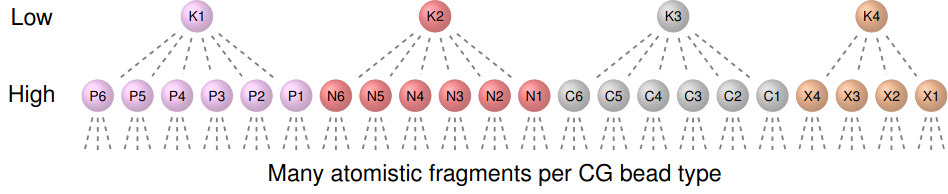
</div>

We will first focus on the two CG levels and come back to the atomistic resolution at the end of the tutorial.

Let's now enumerate all unique CG molecules with two beads for both resolution levels using the function `combinations_with_replacement` from Pythons [itertools](https://docs.python.org/3/library/itertools.html):

In [ ]:
low_res_bead_types = [
    'K1', 'K2', 'K3', 'K4'
]
high_res_bead_types = [
    'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6',
    'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'X1', 'X2', 'X3', 'X4'
]
low_res_molecules = ['-'.join(sorted(beads)) for beads in combinations_with_replacement(low_res_bead_types, 2)]
high_res_molecules = ['-'.join(sorted(beads)) for beads in combinations_with_replacement(high_res_bead_types, 2)]
print(f"Number of low resolution molecules: {len(low_res_molecules)}")
print(f"Low resolution molecules: {low_res_molecules}")
print(f"Number of high resolution molecules: {len(high_res_molecules)}")

From the known mapping between bead types, we can construct a mapping between the molecules at different resolutions:

In [ ]:
bead_mapping = {'X': 'K4', 'C': 'K3', 'N': 'K2', 'P': 'K1'}
def map_bead_types(mol: str) -> str:
    new_beads = [bead_mapping[bead[0]] for bead in mol.split('-')]
    return '-'.join(sorted(new_beads))

mapping = {mol: map_bead_types(mol) for mol in high_res_molecules}
print(f"Example high to low resolution mapping: {high_res_molecules[0]} -> {mapping[high_res_molecules[0]]}")

The idea for the optimization is to use the low-resolution model (with only ten molecules) to roughly estimate the transfer free energies of the high-resolution molecules. This reduces the total number of molecule evaluations required. For example, we evaluate the free energy for the molecule `K4-K4` and use the result to estimate the free energies of all the corresponding high-resolution molecules:

<div style="text-align: center;">
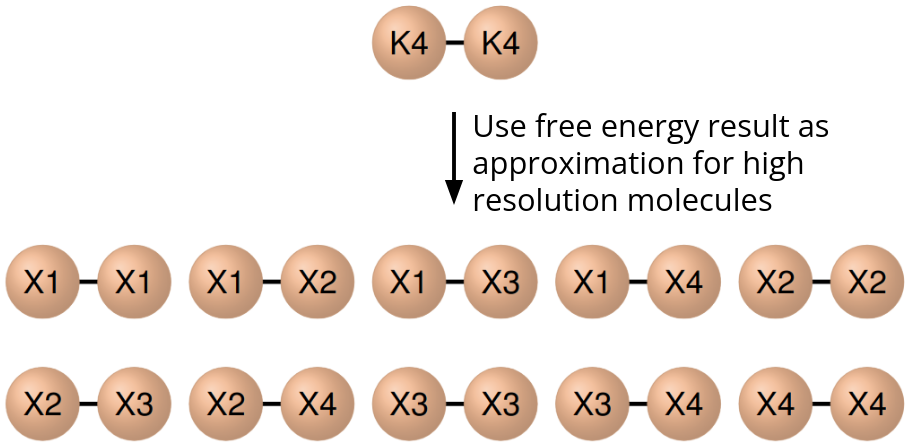
</div>

We would now run simulations and calculate the transfer free energies of all ten low-resolution molecules at this stage. However, to speed things up, we provide the following dictionary with precomputed $\Delta\Delta G$ values:

In [ ]:
low_res_ddG_results = {
    'K1-K1': -1.321, 'K3-K3': -1.025, 'K4-K4': -0.740, 'K3-K4': -0.606, 'K1-K2': -0.056,
    'K2-K3':  0.163, 'K2-K2':  0.601, 'K2-K4':  0.665, 'K1-K4':  0.871, 'K1-K3':  0.983,
}
print(f"ddG_(K3-K4) = {low_res_ddG_results['K3-K4']} kcal/mol")

<span style="color:blue">**TODO:**</span> Compare the result from the dictionary with your simulation result for `K3-K4` from above. The result from your simulations might deviate a bit due to the relatively short simulation times.

## <ins>Encode molecules</ins>
In this section, we will perform a numerical encoding of the discrete set of high-resolution molecules using a [regularized autoencoder (RAE) neural network](https://doi.org/10.48550/arXiv.1903.12436).

**Why do we need a numerical encoding?** Even width a low-resolution estimate or *prior* for all high resolution molecules, evaluating every promising candidate to find the optimal molecule is still impractical—especially for more complex systems than in this tutorial. To explore molecular space more efficiently, we use **Bayesian optimization (BO)**, a method for optimizing expensive functions for which gradient information is unavailable. More details about BO follow in one of the other tutorials. BO allows us to easily incorporate low-resolution information into the search for optimal high-resolution CG molecules. However, BO requires a **similarity or correlation measure between molecules**. To compute this, we numerically encode molecules and use distances in this encoding space to quantify similarity.

<div style="text-align: center;">
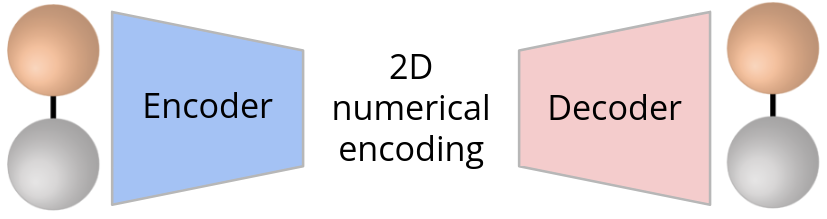
</div>

For larger molecular structures, a graph neural network could be used to encode the molecules. However, since we work with simple two-bead molecules, we use basic [multi-layer perceptrons (MLPs)](https://en.wikipedia.org/wiki/Multilayer_perceptron) instead. Various bead featurizations are possible, and the more information included, the more meaningful the resulting numerical representation. The simplest option, requiring no prior knowledge, is one-hot encoding: with 22 bead types, each bead is represented by a 22-entry vector. If additional information about bead relationships is available, it can be incorporated into the encoding. In our case, we assumed that bead types sharing the same letter have similar properties, so we use separate one-hot encodings for the letter and digit components of the bead names:

In [ ]:
def featurize_molecule(mol: str) -> torch.Tensor:
    """
    Featurization of a two-bead molecule.
    The resulting 20-entry vector has the following structure:
      - 6 bits for the index of the first bead
      - 4 bits for the letter of the first bead
      - 6 bits for the index of the second bead
      - 4 bits for the letter of the second bead
    :param mol: String representation of the molecule ("A-B")
    """
    indices = [int(b[1])-1 for b in mol.split('-')]
    types = [['P', 'N', 'C', 'X'].index(b[0]) for b in mol.split('-')]
    indices_one_hot = one_hot(torch.LongTensor(indices), 6)
    types_one_hot = one_hot(torch.LongTensor(types), 4)
    return torch.cat((indices_one_hot,types_one_hot), dim=1).flatten().float()

Let's check the featurization of the molecule `C1-P1`:

In [ ]:
featurize_molecule('C1-P1')

Next, we define the autoencoder model:

In [ ]:
class Autoencoder(nn.Module):

  def __init__(self):
    super(Autoencoder, self).__init__()
    """ Embedding of the bead types """
    self.embedding = nn.Sequential(
      nn.Linear(10,32), nn.ReLU(True),
      nn.Linear(32,16)
    )
    """ Encodes the concatenated bead type embeddings """
    self.encoder = nn.Sequential(
      nn.Linear(32,128), nn.ReLU(True),
      nn.Linear(128,2)
    )
    """ Decode the one-hot encoded molecule input """
    self.decoder = nn.Sequential(
      nn.Linear(2,128), nn.ReLU(True),
      nn.Linear(128,128), nn.ReLU(True),
      nn.Linear(128,20)
    )

  def encode(self, x: torch.Tensor) -> torch.Tensor:
    embedding1 = self.embedding(x[:,:10]) # First bead
    embedding2 = self.embedding(x[:,10:]) # Second bead
    x = torch.cat((embedding1, embedding2), dim=1)
    return self.encoder(x)

  def decode(self, x: torch.Tensor) -> torch.Tensor:
    return self.decoder(x)

To keep things simple, we concatenate the bead embeddings, resulting in a non-permutation-invariant encoder. This is acceptable here, as the molecules contain only two beads with a fixed order.

Because molecules are permutation invariant, we still need a permutation-invariant loss function. While constructing such a loss is challenging for larger molecules, it is straightforward for two-bead molecules, which have only two possible permutations. We can simply evaluate both and choose the smaller loss.

<span style="color:blue">**TODO:**</span> Using the [`cross_entropy`](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html) and [`minimum`](https://docs.pytorch.org/docs/stable/generated/torch.minimum.html) functions, implement a permutation invariant loss for the molecule reconstruction:

In [ ]:
def invariant_reconstruction_loss(decoded: torch.Tensor, target: torch.Tensor):
    decoded_index1, decoded_class1 = decoded[:,:6], decoded[:,6:10]
    decoded_index2, decoded_class2 = decoded[:,10:16], decoded[:,16:]
    input_index1, input_class1 = target[:,:6], target[:,6:10]
    input_index2, input_class2 = target[:,10:16], target[:,16:]
    # TODO
    # Use: cross_entropy(decoded, target, reduction='none')
    # return torch.minimum(loss1, loss2).mean()

The collapsed code block below shows how the implementation could look like:

In [ ]:
def invariant_reconstruction_loss(decoded: torch.Tensor, target: torch.Tensor):
    decoded_index1, decoded_class1 = decoded[:,:6], decoded[:,6:10]
    decoded_index2, decoded_class2 = decoded[:,10:16], decoded[:,16:]
    input_index1, input_class1 = target[:,:6], target[:,6:10]
    input_index2, input_class2 = target[:,10:16], target[:,16:]
    loss1 = (cross_entropy(decoded_index1, input_index1, reduction='none') +
             cross_entropy(decoded_class1, input_class1, reduction='none') +
            cross_entropy(decoded_index2, input_index2, reduction='none') +
             cross_entropy(decoded_class2, input_class2, reduction='none'))
    loss2 = (cross_entropy(decoded_index1, input_index2, reduction='none') +
             cross_entropy(decoded_class1, input_class2, reduction='none') +
            cross_entropy(decoded_index2, input_index1, reduction='none') +
             cross_entropy(decoded_class2, input_class1, reduction='none'))
    return torch.minimum(loss1, loss2).mean()

With this setup we can run the optimization of our autoencoder model:

In [ ]:
""" Featurize all molecules """
mol_features = torch.stack([featurize_molecule(m) for m in high_res_molecules])
""" Initialize autoencoder model """
model = Autoencoder()
""" Setup ADAM optimizer with decoder regularization """
optimizer = torch.optim.Adam([
    {'params': model.embedding.parameters()},
    {'params': model.encoder.parameters()},
    {'params': model.decoder.parameters(), 'weight_decay': 1e-3}
  ], lr=0.001)

In [ ]:
for epoch in range(3000):
    optimizer.zero_grad()
    encoded = model.encode(mol_features)
    decoded = model.decode(encoded)
    latent_loss = 0.5 * torch.mean(encoded**2) # Latent space regularization
    recon_loss = invariant_reconstruction_loss(decoded, mol_features)
    loss = recon_loss + 0.1 * latent_loss
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}: Loss = {recon_loss.item():.4f}, Latent Loss = {latent_loss.item():.4f}", end='\r')

To reconstruct molecules from the autoencoder prediction, we use the following function based on the [`softmax`](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html) function:

In [ ]:
def molcule_from_autoencoder_prediction(prediction: torch.Tensor) -> str:
    """
    Reconstruct a two-bead molecule from the decoder prediction.
    :param prediction: 20-entry decoder prediction vector
    :return: String representation of the reconstructed molecule
    """
    decoded_index1, decoded_class1 = prediction[:6], prediction[6:10]
    decoded_index2, decoded_class2 = prediction[10:16], prediction[16:]
    bead_classes = ['P', 'N', 'C', 'X']
    index1 = softmax(decoded_index1, dim=0).argmax() + 1
    class1 = bead_classes[softmax(decoded_class1, dim=0).argmax()]
    index2 = softmax(decoded_index2, dim=0).argmax() + 1
    class2 = bead_classes[softmax(decoded_class2, dim=0).argmax()]
    return '-'.join(sorted([f'{class1}{index1}', f'{class2}{index2}']))

Now we analyze the 2d encoding of our molecules. You should get a reconstruction accuracy of over 95%.

In [ ]:
""" Encode and decode all molecules """
encoded = model.encode(mol_features)
decoded = model.decode(encoded)
encoded = encoded.detach().numpy()
""" Iterate over all molecules and check reconstruction """
correct_reconstructions = 0
for n in range(len(high_res_molecules)):
  recon = molcule_from_autoencoder_prediction(decoded[n])
  correct_reconstructions += int(recon == high_res_molecules[n])
  if n % 50 == 0:
    """ Print every 50th molecule reconstruction and target"""
    print(f'Target: {high_res_molecules[n]} Reconstructed: {recon}, Latent space: {encoded[n]}')
""" Print reconstruction accuracy """
print(f'\nReconstruction accuracy: {correct_reconstructions / len(high_res_molecules):.0%}')
""" Visualize molecular encoding space """
visualize_latent_space(latent_space=encoded, molecules=high_res_molecules) # imported from helper.py

<span style="color:blue">**TODO:**</span> Have a look at the encoded molecule space: What structure do you observe in the encoding space?

<span style="color:blue">**TODO:**</span> **(Due to limited time, it is recommended to continue with the rest of the tutorial before working on this)** Can you improve the model architecture or the training hyperparameters? How much can you reduce the number of trainable parameters to still get a reasonable encoding? What happens if you remove (or increase) the latent space regularization (line 5 in the training loop)?

## <ins>Molecular optimization</ins>

We’re now ready to perform the molecular optimization. Recall that our goal is to identify the optimal high-resolution CG molecule for the hexane–water system, using simulation results from low-resolution CG molecules as a prior. So far, we've enumerated low- and high-resolution molecules, obtained free energies for the low resolution set, and encoded all high-resolution molecules into an numerical latent space.

Within this latent space, we perform **Bayesian optimization (BO)**—a strategy for optimizing expensive functions. In our case, each function evaluation requires multiple MD simulations. BO helps us identify the optimal molecule with as few evaluations as possible, typically outperforming random sampling or grid search.

BO works by building a **surrogate model** that predicts both the **value and uncertainty** of the function across the input space. From this, we compute a so-called **acquisition function** that guides the search by balancing **exploration** (uncertain regions) and **exploitation** (promising regions). Maximizing the acquisition function tells us which molecule to evaluate next.

To integrate the information from the low-resolution model, we use a **delta-learning approach**:
$$
\Delta\Delta G_{\text{high res.}}(x) = \Delta\Delta G_{\text{low res.}}\big(\mathcal{M}(x)\big) + \delta(x)
$$
with the high resolution molecule $x$, the high-to-low-resolution mapping function $\mathcal{M}(x)$, and the correction term $\delta(x)$.

First, we intialize a dictionary for the transfer free energy results and calculate the $\Delta\Delta G$ estimate for all high resolution molecules:

In [ ]:
simulation_data = {}
low_resolution_prior = np.array([low_res_ddG_results[mapping[mol]] for mol in high_res_molecules])

We now run a few Bayesian optimization steps. For the surrogate model, we effectively use a [Gaussian Process](https://peterroelants.github.io/posts/gaussian-process-tutorial/) (see the [`helper.py`](helper.py) file for details). To implement the delta-learning approach mentioned above, we first subtract the low-resolution value (line 5, Shift+L to toggle line numbers), fit the model to the resulting differences (line 6), and finally add the low-resolution prior to the result (line 10).

In [ ]:
bo_predictions = [(low_resolution_prior, None)]
for i in range(10):
    """ Setup surrogate model """
    surrogate_model = SurrogateModel(latent_space=encoded)
    """ Subtract low resolution prior and fit surrogate model """
    fit_data = {i: value - low_resolution_prior[i] for i, value in simulation_data.items()}
    surrogate_model.fit(fit_data)
    """ Perform predictions with surrogate model for all molecules """
    mean_prediction, std_prediction = surrogate_model.predict()
    """ Readd low resolution prior to prediction """
    mean_prediction = mean_prediction + low_resolution_prior
    bo_predictions.append((mean_prediction, std_prediction))
    """ Calculate and maximize the acquisition function for unknown molecules """
    current_best = max(simulation_data.values()) if len(simulation_data) > 0 else max(low_res_ddG_results.values())
    af = acquisition_function(mean_prediction, std_prediction, current_best)
    next_index = argmax_width_excluded_indices(af, excluded_indices=simulation_data.keys())
    """ Evaluate next molecule """
    next_molecule = high_res_molecules[next_index]
    print(f'Simulating next molecule: {next_molecule}')
    run_molecule_simulations(next_molecule)
    simulation_result = calculate_free_energy_difference(next_molecule)
    print(f'Free energy difference: {simulation_result:.3f} kcal/mol')
    simulation_data[next_index] = simulation_result

# Get prediction of final surrogate model
surrogate_model = SurrogateModel(latent_space=encoded)
fit_data = {i: value - low_resolution_prior[i] for i, value in simulation_data.items()}
surrogate_model.fit(fit_data)
mean_prediction, std_prediction = surrogate_model.predict()
bo_predictions.append((mean_prediction + low_resolution_prior, std_prediction))

Although the free energy estimates are not highly accurate, and ten evaluations are probably insufficient to find the global optimum in the chemical space, we were able to identify molecules with large $\Delta\Delta G$ values by performing only 20 out of 253 free energy evaluations (including the initial ten low-resolution ones).

Let’s examine the top three molecules and their corresponding transfer free energy results:

In [ ]:
for i, result in sorted(simulation_data.items(), key=lambda x: x[1])[-3:]:
    print(f'{high_res_molecules[i]}: {result:.3f}')
    best_cg_molecule = high_res_molecules[i]

**Congratulations! Without any prior assumptions about the hexane–water system, we successfully discovered coarse-grained (CG) molecules exhibiting the desired properties.**

Based on the properties of the bead types in the best-performing CG molecule, we can now derive chemical design rules for atomistic structures. A straightforward approach to applying CG beads as design guidelines for atomistic systems is demonstrated in the next (optional) section of the tutorial.

### **Tutorial key take-aways:**
1. Coarse-graining models can compress chemical space.
2. Smooth latent space encodings of discrete molecular graphs help optimize molecules.
3. A hierarchical, funnel-like optimization facilitates efficient exploration of chemical space.
4. Bayesian optimization efficiently maximizes expensive black-box functions, such as the mapping from molecular structures to MD-derived properties.

## OPTIONAL: <ins>Analysis and derivation of design rules</ins>

Although slightly limited by the small number of BO steps performed, we can further analyze the optimization process.  

<span style="color:blue">**TODO:**</span> Visualize the BO prediction over the course of the optimization:

In [ ]:
# Interactive plotting: using matplotlib inline and clear_output we get an updateable plot
%matplotlib inline
for i, bo_prediction in enumerate(bo_predictions):
    clear_output(wait=True)
    # TODO: Visualize the BO prediction using a scatterplot, kernel density estimation, etc.
    # We want to observe the change of the low resolution prior over the course of the optimization
    plt.show()
    time.sleep(0.4)

<span style="color:blue">**TODO:**</span> Using the latest predictions and uncertainties from the surrogate model, analyze the overall characteristics of promising CG molecular candidates beyond those already evaluated. What chemical design rules can be derived from these insights?

In [ ]:
# TODO

<span style="color:blue">**TODO:**</span> The files `oco-w-coarse-grained.csv` and `oco-w-fragments.csv` contain octanol water transfer free energies for the different bead types and various organic fragements. Although a simplified approach that ignores some other properties, these values can be used to match atomistic fragments and reconstruct atomistic structures from the CG design rules derived earlier. Implement the matching of octanol water transfer free energies and use the RDKit method [`BRICSBuild`](https://www.rdkit.org/docs/source/rdkit.Chem.BRICS.html) to reconstruct atomistic molecules. The fragments provided in `oco-w-fragments.csv` were derived using the `BRICSDecompose` method and are ready to use with `BRICSBuild`.

In [ ]:
oco_w_cg = pd.read_csv('oco-w-coarse-grained.csv')
oco_w_atomistic = pd.read_csv('oco-w-fragments.csv')
#TODO